# Building Interpretable Models on Imbalanced Data
## Predicting customer churn from a telecom provider 

I've always believed that to truely learn data science you need to practice data science and I wanted to do this project to practice working with imbalanced classes in classification problems. This was also a perfect oppurtinity to start working with [mlflow](https://mlflow.org/) to help track my machine learning experiments: it allows me to track the different models i've used, the parameters i've training with, and the metrics i've recorded.

This project was aimed at predicting customer churn using the teleccomunications data found on [Kaggle](https://www.kaggle.com/c/customer-churn-prediction-2020/overview). That is, we want to be able to predict if a given customer is going the leave the telecom provider based on the infromation we have on that customer. Now why is this useful? Well, if we can predict which customers we think are going to leave **before** they actually leave then we can try to do something about it! For example, we could target them with specific offers, and maybe we could even use the model to provide us insight into what to offer them because we will know, or at least have an idea, as to why they are leaving. 

## Performance vs Interpretability 
It's very important to know and understand the problem/task at hand before we start to even think about writing any code. Would it be useful in this case to build a really powerful model like XGBOOST? No, of course not. Our goal isn't to squeeze every drop of performance out of our model. Our goal is to **understand** why people are leaving so we can actually do something about it and try to get them to stay. In an ideal world we would build a very interpretable model, but in reality we may have to find a happy medium between performance and interpretability. As always, logistic regression would be a good start.

## Model Evaluation
We now need to decide how we are going to evaluate our models and what we are going to be happy with. Personally, I think it's important to decide an end goal beforehand as otherwise it's going to be hard to decide when to stop, squeezing out those extra 1%s is not worth it a lot of the time.

Due to the nature of our data it is likely that our classes are going to be highly imbalanced, with the case we are interested in (customers leaving) being the minority class. This makes selecting the right metric super important.

<img src="data/blog_content/class_imbalance_meme.jpg" width="300" align="center"/>
    
The metrics we are going to be interested in are **precision**, **recall**, and other metrics associated with these. Precision is the ratio of correct positive predictions to the overall number of positive predictions. Recall is the ratio of correct positive predictions to the overall number of positive predictions in the dataset. 
In our case we are looking at trying to retain customers by predicting which customers are going to leave: so we aren't too fussed if we miss-classify some customers as 'churn' when they are not (false positives). If anything, these miss-classifications might be customers that would soon become 'churn' if nothing changes as they may lie on the edge of the decision boundary. So, we are looking to **maximize recall** as it will minimize the number of false negatives. 

We are also going to look at the **F-measure** as it provides a way to express both concerns of precision and recall with a single score - we don't just want to forfeit precision to get 100% recall!

### Model Specifications
Once we have built our final model, we can then use a precision-recall curve to optimize our performance of on the positive (minority class). In this case we are going to assume that stakeholders in our imaginary telecoms business want to **achieve a recall of 0.80** (i.e. we identify 80% of the positive samples correctly) while maximizing precision. 


## Data
* train.csv - the training set. Contains 4250 rows with 20 columns. 3652 samples (85.93%) belong to class churn=no and 598 samples (14.07%) belong to class churn=yes.
* test.csv - the test set. Contains 850 rows with 18 columns.

The 20 columns contain the following information:
* **state**, string. 2-letter code of the US state of customer residence
* **account_length**, numerical. Number of months the customer has been with the current telcom provider
* **area_code**, string="area_code_AAA" where AAA = 3 digit area code.
* **international_plan**, (yes/no). The customer has international plan.
* **voice_mail_plan**, (yes/no). The customer has voice mail plan.
* **number_vmail_messages**, numerical. Number of voice-mail messages.
* **total_a_b** with **a = (day, eve, night, intl)** and **b = (minutes, calls, charge)**, numerical. Total (minutes, calls, charge) of (day, eve, night, intl) calls.
* **number_customer_service_calls**, numerical. Number of calls to customer service
* **churn**, (yes/no). Customer churn - target variable.

In [2]:
import pandas as pd
from src.data.load_data import read_params
# load in training data 
config = read_params("params.yaml")
external_data_path = config["external_data_config"]["external_data_csv"]
df = pd.read_csv(external_data_path, sep=",", encoding="utf-8")
# check we have our 20 cols
assert len(df.columns) == 20

EDA (along with the all the modeling etc.) was done in different python scripts and I have chosen to not include it here as it is irrelevant to the topic I am writing about. It is nonetheless very important and you can find this whole project on my [Github page](https://github.com/jackmleitch/CustomerChurn). 


Due to the high cardinality of the state columns we need to be careful when encoding them otherwise we will end up with 50 different features!

In [3]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


We can look at a correlation matrix to see any initial promising features.

<AxesSubplot:>

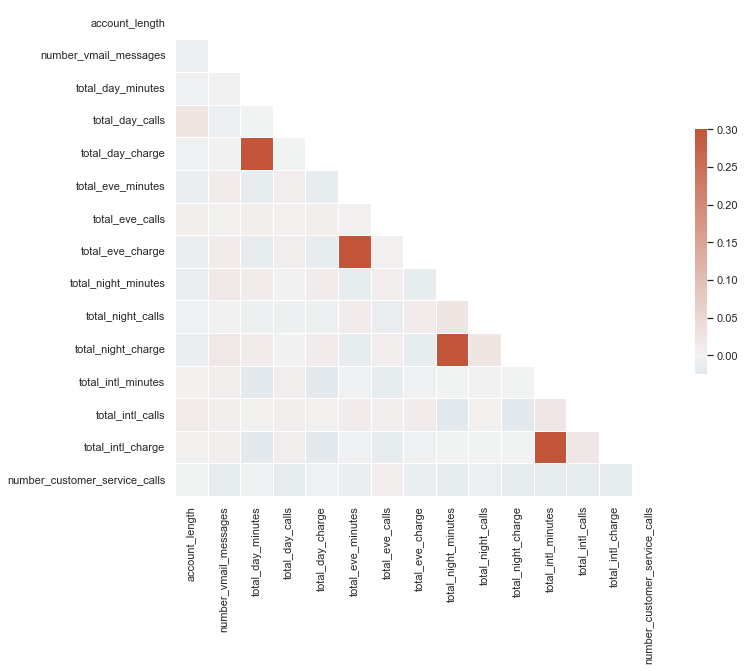

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Ok, this doesn't look great but we can see that churn is somewhat correlated with total_day_minutes, total_day_charge, and number_customer_service_calls. Let's build a simple **baseline model** with total_day_minutes and number_customer_service_calls (we omit total_day_charge because it's strongly correlated with total_day_minutes).

### Feature Engineering
We can generate a few features to encapsulate daily totals. We also map the state feature to the regions the state belongs to as it massively reduces the feature dimensionality. Finally, we can map churn target value to binary as this is required for a lot of models. 

In [5]:
def preprocess(df):
    # add new features
    df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
    df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']
    df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] 
    # target mapping
    target_mapping = {"no": 0, "yes": 1}
    df.loc[:, 'churn'] = df['churn'].map(target_mapping)
    # map state 
    state_mapping = {
        'AK': 'O', 'AL': 'S', 'AR': 'S', 'AS': 'O', 'AZ': 'W', 'CA': 'W', 'CO': 'W', 'CT': 'N', 'DC': 'N', 'DE': 'N', 'FL': 'S', 'GA': 'S',
        'GU': 'O', 'HI': 'O', 'IA': 'M', 'ID': 'W', 'IL': 'M', 'IN': 'M', 'KS': 'M', 'KY': 'S', 'LA': 'S', 'MA': 'N', 'MD': 'N', 'ME': 'N',
        'MI': 'W', 'MN': 'M', 'MO': 'M', 'MP': 'O', 'MS': 'S', 'MT': 'W', 'NA': 'O',  'NC': 'S', 'ND': 'M', 'NE': 'W', 'NH': 'N', 'NJ': 'N',
        'NM': 'W', 'NV': 'W', 'NY': 'N', 'OH': 'M', 'OK': 'S', 'OR': 'W', 'PA': 'N', 'PR': 'O', 'RI': 'N', 'SC': 'S', 'SD': 'M', 'TN': 'S', 
        'TX': 'S', 'UT': 'W', 'VA': 'S', 'VI': 'O', 'VT': 'N', 'WA': 'W', 'WI': 'M', 'WV': 'S', 'WY': 'W'
    }
    df.loc[:, 'state'] = df['state'].map(state_mapping)
    return df
# preprocess dataframe and add features
df = preprocess(df)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge
0,M,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,611.5,329,55.54
1,N,137,area_code_415,no,no,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,527.2,328,59.00
2,M,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,558.2,248,65.02
3,S,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,501.9,356,49.36
4,N,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,...,118,9.57,7.5,7,2.03,3,0,779.3,314,76.28


## Modeling   
The first thing that always needs to be done is to split the data into train and validation sets as it is a vital step to avoid overfitting, improve generalizability, and it helps us compare potential models. In this case we use stratified K-fold cross-validation as our dataset is highly imbalanced and we want to ensure the class distribution is consistent across folds. 

In [6]:
from sklearn.model_selection import StratifiedKFold

def stratKFold(df, n_splits=5):
    """
    Perform stratified K fold cross validation on training set
    :param df: pd dataframe to split
    :param n_splits: number of folds 
    :return: df with kfold column
    """
    # create new column 'kfold' with val -1
    df["kfold"] = -1
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # target values
    y = df['churn'].values
    # initialise kfold class
    kf = StratifiedKFold(n_splits=n_splits)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, "kfold"] = f
    return df
        
df = stratKFold(df)

### Baseline Model
We start by building a simple baseline model so that we have something to compare our later models to. In a regression scenario we could simply use the average of the target variable at every prediction, in our classification case however we are going to use a logistic regression model trained on our two most correlated features. 

Before we start lets initialize Mlflow and write a general scoring function to evaluate our model.

In [7]:
import mlflow 
from sklearn.metrics import f1_score, recall_score, precision_score

# initialize mlflow
mlflow.set_experiment("mlflow/customer_churn_model")

# scoring function 
def score(y, preds):
    """
    Returns corresponding metric scores 
    :param y: true y values
    :param preds: predicted y values
    :return: f1_score, recall, and precision scores 
    """
    f1 = f1_score(y, preds)
    recall = recall_score(y, preds)
    precision = precision_score(y, preds)
    return [f1, recall, precision]

Now let's build our baseline model and see how it does on each validation set!

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# baseline model
f1_scores, recall_scores, precision_scores = [], [], []
for fold in range(5):
    # define train and validation set
    features = ["total_day_minutes", "number_customer_service_calls"]
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # target and features
    y_train = df_train['churn'].values
    y_valid = df_valid['churn'].values
    # init and fit scaler 
    scaler = StandardScaler()
    x_train = scaler.fit_transform(df_train[features])
    x_valid = scaler.transform(df_valid[features])
    # create and train model
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    preds = clf.predict(x_valid)
    # score model
    scores = score(y_valid, preds)
    f1_scores.append(scores[0])
    recall_scores.append(scores[1])
    precision_scores.append(scores[2])
# average scores over each fold
f1_avg = np.average(f1_scores)
recall_avg = np.average(recall_scores)
precision_avg = np.average(precision_scores)
print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")

# log metrics on mlflow 
with mlflow.start_run(run_name="lr_baseline") as mlops_run:
        mlflow.log_metric("F1", f1_avg)
        mlflow.log_metric("Recall", recall_avg)
        mlflow.log_metric("Preision", precision_avg)

Average F1 = 0.08725760427444854, Recall = 0.04847338935574229, Precision = 0.440932400932401


So yea, the results aren't great (actually they are terrible) but that only means we are going to get better. This was only a baseline! We can try a few things to improve our model: 
* We can balance out our classes by over and under-sampling as the imbalance is causing bias towards the majority class in our model.
* We can train on more features.

### SMOTE: To Over-Sample the Minority Class
One problem we have with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem would be to over-sample the examples in the minority class. This could be achieved by simply duplicating examples from the minority class in the training dataset, although this does not provide any additional information to the model. An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. A common technique for this, introduced in [this paper](https://arxiv.org/abs/1106.1813), is SMOTE. It's worth noting that over sampling isn't our only option, we could for example  under-sample (or combine a mix of the two) by using a technique such as [TOMEK-links](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Tomek_links) (SMOTE-TOMEK helps do both under and over-sampling in one go). In our case however, the best performance boost came from SMOTE alone. 

Before we do this however, lets write a general feature processing pipeline to get our data ready for modeling. Our function returns a Sklearn pipeline object that we can use to fit and transform our data. It first splits the data into numeric, categorical features, and binary features as we process each of these differently. The categorical features are encoded using one-hot encoding, while the binary features are left alone. Finally, the numeric features have their missing values imputed. Scaling the numeric features was also tried but it didn't lead to a performance increase. It's also in our best interest to not scale these as it makes interpreting the results harder.

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from mlxtend.feature_selection import ColumnSelector
from category_encoders import HashingEncoder

def feature_pipeline(config_path="params.yaml"):
    """
    :param config_path: path to params.yaml file
    :return: preprocessing feature pipeline 
    """
    # load in config information
    config = read_params(config_path)
    num_features = config["raw_data_config"]["model_features"]["numeric"]
    cat_features = config["raw_data_config"]["model_features"]["categorical"]
    binary_features = config["raw_data_config"]["model_features"]["binary"]

    # transformers
    transforms = []
    # categorical pipeline
    transforms.append(
        (
            "categorical",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=cat_features)),
                    ("encode", OneHotEncoder()),
                ]
            ),
        )
    )
    transforms.append(
        (
            "binary",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=binary_features)),
                    ("encode", OrdinalEncoder()),
                ]
            ),
        )
    )
    # numeric pipeline
    transforms.append(
        (
            "numeric",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=num_features)),
                    ("impute", SimpleImputer(missing_values=np.nan, strategy="median")),   
                ]
            ),
        )
    )
    
    # combine features
    features = FeatureUnion(transforms)
    return features

A general training function is written below, notice we can choose whether we want to use SMOTE or not. The sampling strategy in SMOTE controls how much we resample the minority class and it's something we can tune later.

In [10]:
from imblearn.over_sampling import SMOTE, SMOTENC
def train(fold, df, model=LogisticRegression(solver='newton-cg'), smote=False):
    """
    :param fold: fold to train model on
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param smote: float, if named it is the sampling strategy for SMOTE
    :return: f1, recall, precision validation score for fold, as well as y_valid and preds
    """
    # feature pipeline
    features = feature_pipeline()

    # define train and validation set
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # target and features
    y_train = df_train['churn'].values
    y_valid = df_valid['churn'].values

    # create training and validation features
    x_train = features.fit_transform(df_train)
    x_valid = features.transform(df_valid)

    # smote
    if smote:
        smt = SMOTE(random_state=42, sampling_strategy=smote) 
        x_train, y_train = smt.fit_resample(x_train, y_train)

    # create and train model
    clf = model
    clf.fit(x_train, y_train)
    preds = clf.predict(x_valid)
    # score model
    scores = score(y_valid, preds)
    return scores, [y_valid, preds]

Before we use SMOTE, let's train a logistic regression model on all of the features to try and get a new baseline.  

In [11]:
f1_scores, recall_scores, precision_scores = [], [], []
for fold in range(5):
    scores, _ = train(fold,df, smote=False)
    f1, recall, precision = scores
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
# average scores over each fold
f1_avg = np.average(f1_scores)
recall_avg = np.average(recall_scores)
precision_avg = np.average(precision_scores)
print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")
# log metrics on mlflow 
with mlflow.start_run(run_name="lr_all_features") as mlops_run:
        mlflow.log_metric("F1", f1_avg)
        mlflow.log_metric("Recall", recall_avg)
        mlflow.log_metric("Preision", precision_avg)

Average F1 = 0.3066722566642678, Recall = 0.2107563025210084, Precision = 0.5720696669209255


The results are definitely better than before but still not great. We've waited long enough, let's try using SMOTE! We are going to use SMOTE to over-sample our churn datapoints so that we end up with equal class distributions. 

In [12]:
def train_and_eval(df, model=LogisticRegression(solver='newton-cg'), smote=0.75, model_name="", params = {}, log_mlflow=True):
    '''
    train model and evaluate it on each fold
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param model_name: string, for tracking on mlflow
    :param params: dict, for tracking on mlflow
    :param log_mlflow: boolean, if true then log results using mlflow
    :return: average score for each metric
    '''
    f1_scores, recall_scores, precision_scores = [], [], []
    for fold in range(5):
        scores, _ = train(fold, df, model=model, smote=smote)
        f1, recall, precision = scores
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
    # average scores over each fold
    f1_avg = np.average(f1_scores)
    recall_avg = np.average(recall_scores)
    precision_avg = np.average(precision_scores)
    print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")
    # log metrics on mlflow 
    if log_mlflow:
        with mlflow.start_run(run_name=model_name) as mlops_run:
                mlflow.log_metric("F1", f1_avg)
                mlflow.log_metric("Recall", recall_avg)
                mlflow.log_metric("Preision", precision_avg)
                if params:
                    mlflow.log_params(params)
    return f1_avg

An important side note: when using SMOTE we need to evaluate performance on a validation set which has **not** been over-sampled. Otherwise, we will not be getting a true performance measure.

In [13]:
train_and_eval(df, model_name="lr_all_features_smote")

Average F1 = 0.49789052753778434, Recall = 0.6906862745098039, Precision = 0.3894759793369957


0.49789052753778434

Wow! We have boosted the F1 score from 0.31 to 0.50, and the recall has gone from 0.21 to 0.69! An important note is that the precision has practically stayed the same. Why is that? Well, what is precision measuring? Mathematically, precision the number of true positives divided by the number of true positives plus the number of false positives. It tells us that our model is correct 47% of the time when trying to predict positive samples. So by over-sampling we have decreased the number of false negatives but we have also increased the number of false positives. This is OK as we decided we will favor false positives over false negatives. An intuitive way to see this change is by looking at a **confusion matrix**. 

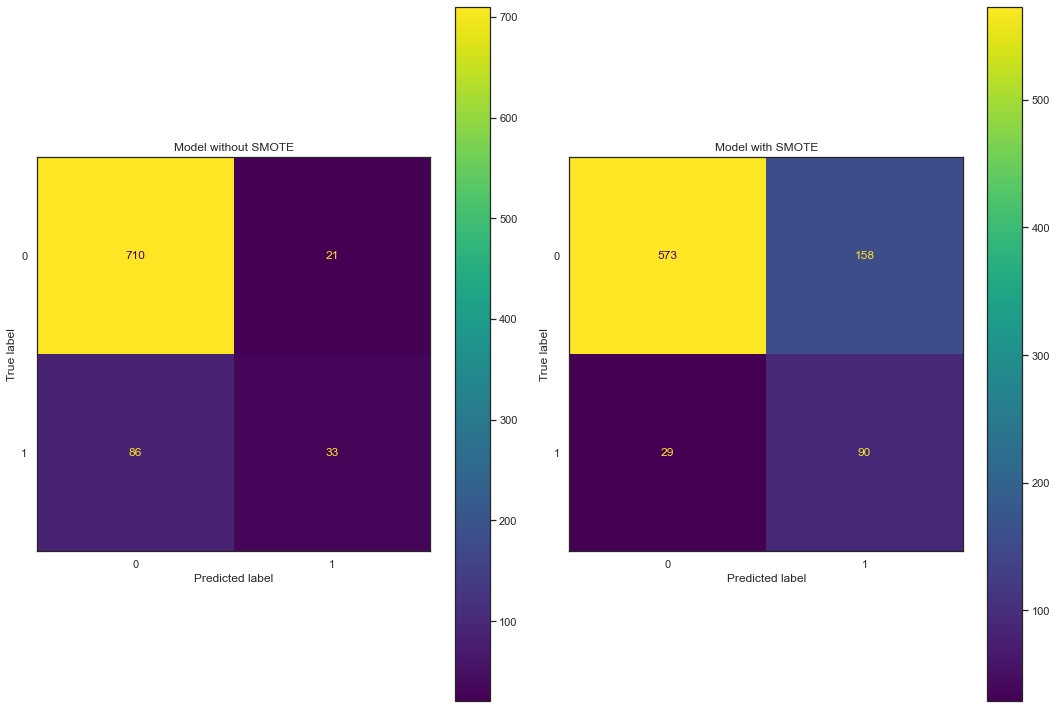

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# get preds for non-smote and smote models
_, evals = train(0, df, smote=False)
_, evals_smote = train(0, df, smote=True)
# set axis and plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.set_title("Model without SMOTE")
ConfusionMatrixDisplay.from_predictions(*evals, ax=ax1)
ax2.set_title("Model with SMOTE")
ConfusionMatrixDisplay.from_predictions(*evals_smote, ax=ax2)
plt.tight_layout()  
plt.show()

We can see that the TP number goes from 33 to 90 and the FN number goes from 86 to 29, great! However, as a consequence of this we see the FP number goes from 21 to 158. But, as mentioned earlier, we are ok with that as we care more about finding out which customers are going to leave. 
A little side note: the FP and FN rates can be tuned using the probability threshold and the easiest way to compare the two models is to compare F1 scores.

## Feature Selection 
We can train a more complicated model and then use this to select features. Specifically, we train a random forest classifier and then use SHAP values to select the most promising features. Narrowing down the feature space helps reduce dimensionality and generalizability while also making interpreting results easier. It's a win win!

In [15]:
from sklearn.ensemble import RandomForestClassifier
features = feature_pipeline()
X = np.asarray(features.fit_transform(df).todense())
y = df['churn'].values

clf = RandomForestClassifier()
model = clf.fit(X,y)

import shap 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [16]:
# get feature names
num_features = config["raw_data_config"]["model_features"]["numeric"]
cat_features = config["raw_data_config"]["model_features"]["categorical"]
bin_features = config["raw_data_config"]["model_features"]["binary"]
cat_features = features.transformer_list[0][1][1].get_feature_names_out(cat_features)
feature_names = list(cat_features) + list(bin_features) + list(num_features)

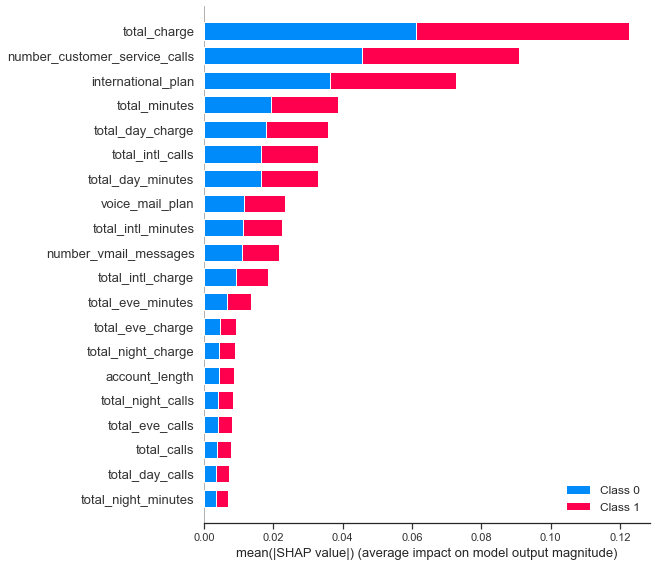

In [17]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names, plot_type='bar')

In [18]:
features_keep = [
    'total_charge', 'number_customer_service_calls', 'international_plan', 'total_day_minutes', 'total_day_charge', 
    'total_minutes', 'total_intl_calls', 'voice_mail_plan', 'total_intl_minutes', 'number_vmail_messages', 'total_intl_charge'
]

We can now define a new pipeline to preprocess and only select our needed features. 

In [19]:
def feature_pipeline():
    """
    :return: preprocessing feature pipeline with selected features
    """
    # different features
    numeric_features = [
        'total_charge', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 
        'total_minutes', 'total_intl_calls', 'total_intl_minutes', 'number_vmail_messages', 'total_intl_charge'
    ]
    binary_features = ['international_plan', 'voice_mail_plan']

    # transformers
    transforms = []
    
    transforms.append(
        (
            "binary",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=binary_features)),
                    ("encode", OrdinalEncoder()),
                ]
            ),
        )
    )
    # numeric pipeline
    transforms.append(
        (
            "numeric",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=numeric_features)),
                    ("impute", SimpleImputer(missing_values=np.nan, strategy="median")),   
                ]
            ),
        )
    )
    
    # combine features
    features = FeatureUnion(transforms)
    return features

Let's see how our logistic regression model does with our narrowed down features!

In [20]:
train_and_eval(df, model_name="lr_selected_features_smote")

Average F1 = 0.5025520964212148, Recall = 0.6940336134453782, Precision = 0.3940789241235847


0.5025520964212148

Awesome, we've removed features and our performance increases slightly. This confirms to us that the other features weren't important.

### But can we do better than our logistic regression?
It would be easy here to go all guns blazing and train an XGBOOST model, but remember that is **not** our goal. Our goal is to build an **interpretable** model that we can use to try and keep customers from leaving. 
As well as logistic regression, decision tree classifiers are very interpretable. Let's see how it gets on.

In [21]:
from sklearn.tree import DecisionTreeClassifier
train_and_eval(df, model=DecisionTreeClassifier(), model_name="dt_selected_features_smote")

Average F1 = 0.8152920749388362, Recall = 0.8461484593837536, Precision = 0.786946006985776


0.8152920749388362

It does well! We need to be **very** careful though as decision trees overfit like there is not tomorrow. Let's go ahead and tune hyperparameters on both models to see if we can optimize things a little more. We will use [Optuna](https://optuna.org/) as I just love how easy and fast it is. 

### Hyperparameter Tuning

We need a be super careful here, decision trees are very prone to overfitting and this is why random forest models are usually preferred. The random forest can generalize over the data in a better way as the randomized feature selection acts as a form of regularization. As discussed earlier though, in our case we care more about interpretability than performance. Now, although cross-validation is great for seeing how the model is generalizing, it doesn't necessarily prevent overfitting as we will just end up overfitting the validation sets. 

One measure of overfitting is when the training score is much higher than the testing score. I initially tried setting the objective function in the Optuna trial to the cross-validated validation scores but this still lead to overfitting as DTs don't have much regularization. 

Another possibility, that is this case worked superbly, is weighting the difference between cross-validated training scores and validation scores vs the validation score itself. For example, for F1 scores, a possible objective function is

$$ \sqrt{(\overline{F1}_{\mathrm{valid}} - \overline{F1}_{\mathrm{train}})^2} + 4(1 - \overline{F1}_{\mathrm{valid}})$$
In this case the RMSE of the difference between validation and training is weighted four times less than the validation F1 score.
Optimizing this function forces the train and valid score to stay close, while also maximizing the validation score.

In [22]:
def train_valid_f1_score(mean_train, mean_test):
    '''
    RMSE of the difference between testing and training is weighted four times less than the test accuracy 
    '''
    return np.sqrt((mean_test - mean_train)**2) + 4 * (1 - mean_test)

In [24]:
from optuna import Trial, create_study
from optuna.samplers import TPESampler
from scipy.stats import loguniform

def objective(trial, n_jobs=-1, random_state=42):
    '''
    Objective function to optimize our custom metric using Optuna's TPE sampler
    '''
    # smote param space 
    smote_space = {'sampling_strategy': trial.suggest_uniform('sampling_strategy', 0.5, 1)}
    # define search spaces
    if model == LogisticRegression:
        params = {
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']), 
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': trial.suggest_float("C", 1.0, 10.0, log=True),
            'tol': trial.suggest_float("tol", 0.0001, 0.01, log=True),
            'max_iter': trial.suggest_int('max_iter', 100, 1000)

        }
    else:
        params = {
            'max_depth': trial.suggest_int('max_depth',2,10), 
            'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
            'min_samples_split': trial.suggest_int('min_samples_split',2,10),
            'criterion': trial.suggest_categorical('criterion', ["gini", "entropy"])
        }
        
    # feature pipeline
    features = feature_pipeline()
    # create training and validation features
    X = features.fit_transform(df)
    y = df['churn'].values

    train_f1, valid_f1 = [], []
    # Create StratifiedKFold object.
    strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
    for train_index, test_index in strat.split(X, y):
        # split data
        x_train, x_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        # feature transformations and smote
        smt = SMOTE(random_state=42, **smote_space) 
        x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)
        # train model
        clf = model(**params)
        clf.fit(x_train_smt, y_train_smt)
        # compute f1 score on valid and training data (without SMOTE!)
        preds_train = clf.predict(x_train)
        preds_valid = clf.predict(x_valid)
        train_f1.append(f1_score(y_train, preds_train))
        valid_f1.append(f1_score(y_valid, preds_valid))
    # compute mean of f1 train/valid scores
    train_f1_mean, valid_f1_mean = np.array(train_f1).mean(), np.array(valid_f1).mean()
    # train/test cross score 
    return train_valid_f1_score(train_f1_mean, valid_f1_mean)

In [25]:
# model to optimize
model = DecisionTreeClassifier

# Bayesian sampler 
sampler = TPESampler()
study = create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# # display params
# best = study.best_params
# for key, value in best.items():
#     print(f"{key:>20s} : {value}")
# print(f"{'best objective value':>20s} : {study.best_value}")

[I 2021-12-28 15:03:39,797] A new study created in memory with name: no-name-eeeda589-2aad-4745-9c2f-ceca0dde2dce


This gives us the following results:
* **Logistic Regression** Best Hyperparameters: {'solver' : 'liblinear', 'penalty' : 'l2', 'C' : 1.14, 'tol' : 0.0002, max_iter : 150}
* **Decision Tree** Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'criterion': 'gini'},
* **SMOTE SAMPLING STRATEGY** 0.70 for LR and 0.56 for DT

Let's train some model with these parameters and see what we get!

In [27]:
def train(df, model, params, sampling_strategy):
    '''
    Train model and output both training and validation f1 scores
    :param df: pandas dataframe of our data
    :param model: model to train
    :param params: dict, model hyperparams
    :param sampling_strategy: float, sampling strat for SMOTE
    :return: prints training and validation F1 scores
    '''
    # feature pipeline
    features = feature_pipeline()
    # create training and validation features
    X = features.fit_transform(df)
    y = df['churn'].values

    train_f1, valid_f1 = [], []
    # Create StratifiedKFold object.
    strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
    for train_index, test_index in strat.split(X, y):
        # split data
        x_train, x_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        # feature transformations and smote
        smt = SMOTE(random_state=42, sampling_strategy=sampling_strategy) 
        x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)
        # train model
        clf = model(**params)
        clf.fit(x_train_smt, y_train_smt)
        # compute f1 score on valid and training data (without SMOTE!)
        preds_train = clf.predict(x_train)
        preds_valid = clf.predict(x_valid)
        train_f1.append(f1_score(y_train, preds_train))
        valid_f1.append(f1_score(y_valid, preds_valid))
    # compute mean of f1 train/valid scores
    train_f1_mean, valid_f1_mean = np.array(train_f1).mean(), np.array(valid_f1).mean()
    # train/test cross score 
    print(f"Average training F1 score {train_f1_mean}")
    print(f"Average validation F1 score {valid_f1_mean}")
    print(f"Overfit score {train_valid_f1_score(train_f1_mean, valid_f1_mean)}")

In [28]:
params = {'solver' : 'liblinear', 'penalty' : 'l2', 'C' : 1.14, 'tol' : 0.0002, 'max_iter' : 150}
train(df, LogisticRegression, params, 0.70)

Average training F1 score 0.5009518013999269
Average validation F1 score 0.5034031228088905
Overfit score 1.9888388301734015


In [29]:
params = {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'criterion': 'gini'}
train(df, DecisionTreeClassifier, params, 0.70)

Average training F1 score 0.9153416502877135
Average validation F1 score 0.8928098706544405
Overfit score 0.451292297015511


Although this model looks great and doesn't appear to be overfitting we are going to go with the model below that has been tuned with a lower maximum depth. Our goal is interpretability and a depth of 7 doesn't really give us that. So we are sacrificing a little bit of accuracy for interpretability.

In [30]:
params = {'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 17, 'criterion': 'entropy'}
train(df, DecisionTreeClassifier, params, 0.78)

Average training F1 score 0.8217456929425225
Average validation F1 score 0.816103270284813
Overfit score 0.7412293415184575


In [31]:
with mlflow.start_run(run_name="dt_tuned") as mlops_run:
        mlflow.log_metric("F1", 0.8161)

Great, so we now have a few potential models. We are going to move forward with the decision tree model as the logistic regression model isn't quite up to scratch. 

### Pruning the Decision Tree
Although our model doesn't appear to be overfitting, we are still going to prune the decision tree as it helps us get rid of sub-nodes that don't have much predictive power. We do this with the hope that this helps our model generalize better. An added bonus, that tends to come with most regularization, is that it also helps improve the interpretability of the model. 

We can prune our tree by picking the right cost complexity parameter. We will start by training a model on the whole dataset, with our chosen hyperparams, to find our space of $\alpha$'s - the cost complexity parameter.

In [34]:
def train_full(df, model, params, smote=0.78):
    """
    train model on whole dataset
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param params: dict, model hyperparameters
    :return: trained model and feature transformation pipeline
    """
    # feature pipeline
    features = feature_pipeline()

    # target and features
    x_train = features.fit_transform(df)
    y_train = df['churn'].values

    smt = SMOTE(random_state=42, sampling_strategy=smote)
    x_train, y_train = smt.fit_resample(x_train, y_train)

    # create and train model
    clf = model(**params)
    clf.fit(x_train, y_train)
    return clf, features

In [35]:
# train full model 
params = {'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 17, 'criterion': 'entropy'}
clf, features = train_full(df=df, model=DecisionTreeClassifier, params=params)

In [36]:
# get cost complexity alphas from model
ccp_alphas = clf.cost_complexity_pruning_path(x_train, y_train)['ccp_alphas']
ccp_alphas

array([0.        , 0.00057893, 0.00059309, 0.00098679, 0.00117254,
       0.0019927 , 0.00322822, 0.00418948, 0.00719436, 0.00811411,
       0.02386822, 0.06419409])

We can then score each of these $\alpha$'s in a cross-validated way to find the best complexity to choose.

In [38]:
def search_alpha_space(alphas, df=df):
    '''
    Cross validated scoring of each ccp_alpha 
    :param alphas: list, ccp_alphas from trained model 
    :param df: pandas dataframe 
    :return: dict, of alphas and avergae corresponding validation F1 score
    '''
    # optimized parameters
    params = {'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 17, 'criterion': 'entropy'}
    sampling_strategy = 0.78
        
    # feature pipeline
    features = feature_pipeline()
    # create training and validation features
    X = features.fit_transform(df)
    y = df['churn'].values

    f1 = {}
    # Create StratifiedKFold object.
    strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
    for alpha in alphas:
        score = []
        for train_index, test_index in strat.split(X, y):
            # split data
            x_train, x_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]
            # feature transformations and smote
            smt = SMOTE(random_state=42, sampling_strategy=0.78) 
            x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)
            # train model
            clf = DecisionTreeClassifier(ccp_alpha=alpha, **params)
            clf.fit(x_train_smt, y_train_smt)
            # compute f1 score on valid and training data (without SMOTE!)
            preds_valid = clf.predict(x_valid)
            score.append(f1_score(y_valid, preds_valid))
        f1[f'{alpha}'] = np.array(score).mean()
    return f1

optim_alpha = search_alpha_space(ccp_alphas)

# print scored alphas
from pprint import pprint 
pprint(optim_alpha)

{'0.0': 0.816103270284813,
 '0.0005789325156238256': 0.816103270284813,
 '0.0005930920192462885': 0.816103270284813,
 '0.0009867859833913376': 0.816103270284813,
 '0.0011725425508943704': 0.816103270284813,
 '0.0019927001338321468': 0.816103270284813,
 '0.003228215942898363': 0.816103270284813,
 '0.0041894808849862325': 0.816103270284813,
 '0.007194356040110275': 0.8142671700825213,
 '0.00811411007422369': 0.8147206576154481,
 '0.023868223077443323': 0.7667293021998818,
 '0.06419408989742087': 0.6540410407393117}


We can see that the value $\alpha = 0.00811411$ is the best complexity to choose. In general, as $\alpha$ increases the number of nodes and depth decreases. So we pick the highest $\alpha$ value that still has a good average F1 score.

We can now train our final model!

In [55]:
params = {'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 17, 'criterion': 'entropy', 'ccp_alpha': 0.00811411}
clf, features = train_full(df=df, model=DecisionTreeClassifier, params=params)

### How Does It Perform on Test Data

In [66]:
def preprocess(df, target=False):
    '''
    Preprocessing unseen data by adding features and mapping target variable
    :param df: pandas dataframe 
    :param target: str, default False but if true and a string then map target to binary
    :return: processed dataframe
    '''
    # add new features
    df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
    df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] 
    # target mapping if req.
    if target:
        target_mapping = {"no": 0, "yes": 1}
        df.loc[:, f'{target}'] = df[f'{target}'].map(target_mapping)
    return df

def predict(X, clf, feature_pipeline, thresh=0.5):
    '''
    Predict customer churn on new data 
    :param X: data containing features
    :param clf: trained model
    :param feature_pipeline: trained feature processing pipeline
    :param thresh: prediction threshold
    :return: predictions
    '''
    X = feature_pipeline.transform(X)
    preds = (clf.predict_proba(X)[:,1] >= thresh).astype(int)
    return preds

In [67]:
# load in test data and score
df_test = pd.read_csv("data/external/test.csv")
# preprocess data
df_test = preprocess(df_test, target='churn')
# target mapping
y_test = df_test['churn'].values
# predict on unseen data
preds = predict(df_test, clf, features)
# score
f1, recall, precision = score(y_test, preds)
print(f"Average F1 = {f1}, Recall = {recall}, Precision = {precision}")

Average F1 = 0.7772925764192139, Recall = 0.6592592592592592, Precision = 0.9468085106382979


In [76]:
with mlflow.start_run(run_name="dt_final_test_data") as mlops_run:
        mlflow.log_metric("F1", 0.777)
        mlflow.log_metric("Recall", 0.659)
        mlflow.log_metric("Preision", 0.947)

The model does well on the test data! We can see that the precision is a lot higher than the recall however but this is something that can be tuned by changing the prediction probability threshold. In our case we are trying to get to 80% recall while maximizing precision.

### Picking the Optimal Probability Threshold

We can now tune the probability threshold to try and optimize our precision recall trade-off. Let's plot a precision recall curve and find the optimal threshold to achieve 80% recall. 

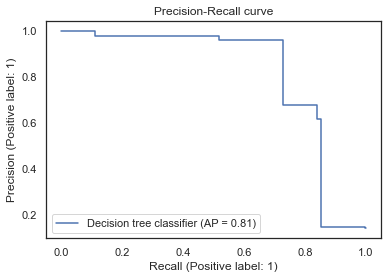

In [69]:
from sklearn.metrics import PrecisionRecallDisplay
# training data
x_train = features.transform(df)
y_train = df['churn'].values
# precision recall curve
display = PrecisionRecallDisplay.from_estimator(
    clf, x_train, y_train, name="Decision tree classifier"
)
_ = display.ax_.set_title("Precision-Recall curve")

In [72]:
from sklearn.metrics import precision_recall_curve
def optimize_threshold(clf, df, recall = 0.80):
    '''
    Optimize prob. threshold on training dataset 
    :param df: pandas dataframe
    :param recall: desired recall 
    :return: optimal prob. threshold
    '''    
    # create features and target labels
    X = features.transform(df)
    y = df['churn'].values

    # get scores for valid data
    y_scores = clf.predict_proba(X)[:, 1]
    # locate where recall is closest to 0.80
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    distance_to_optim = abs(recalls - recall)
    optimal_idx = np.argmin(distance_to_optim)
    thresh = thresholds[optimal_idx]
    return thresh

thresh = optimize_threshold(clf, df)
print(thresh)

0.4263565891472868


If we predict on our test set again then hopefully we will see something closer to our desired recall! And yes, I know i've committed the cardinal sin of using the test set twice but this was for demonstration purposes. The test set is normally a 'one and done' situation. 

In [78]:
# predict on unseen data
preds = predict(df_test, clf, features, thresh=0.426)
# score
f1, recall, precision = score(y_test, preds)
print(f"Average F1 = {f1}, Recall = {recall}, Precision = {precision}")
with mlflow.start_run(run_name="dt_final_test_data_threshold_tuning") as mlops_run:
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("Preision", precision)
        mlflow.log_metric("Recall", recall)

Average F1 = 0.7958477508650519, Recall = 0.8518518518518519, Precision = 0.7467532467532467


Awesome! We have done what we wanted to do, and things work well! It's also great to see test scores so similar to our earlier scores as it shows we haven't overfitted our model. Let's log this model on MLFLOW.

In [79]:
# log metrics on mlflow 
with mlflow.start_run(run_name="Final Decision Tree") as mlops_run:
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("Preision", precision)
        mlflow.log_params(params)
        mlflow.log_params({"prob_thresh": 0.426})
        # log model and pipeline
        mlflow.sklearn.log_model(clf, "clf")
        mlflow.sklearn.log_model(features, "features_pipeline")

In [81]:
# import pickle

# with open('models/final_DT_model.pickle', 'wb') as f:
#     pickle.dump(clf, f)

# with open('models/feature_pipeline.pickle', 'wb') as f:
#     pickle.dump(features, f)

### MLFLOW Experiment Session
<img src="data/blog_content/mlflow.png"/>

Oops, I've miss-spelled precision... oh well.

## Model Interpreting 

Tree based models split the data multiple times according to certain cutoff values in the features. By splitting, different subsets of the dataset are created, where each instance belonging to a certain subset. To predict the outcome in each leaf node, the average outcome of the training data in this node is used. 

The interpretation for decision trees are very easy: Starting from the root node, you go to the next nodes and the edges tell you which subsets you are looking at. Once you reach the leaf node, the node tells you the predicted outcome. All the edges are connected by ‘AND’.

So the general way we can predict is: If feature x is **smaller** (/bigger) than threshold c **AND** ... then the predicted outcome is the most common value of the target of the instances in that node. 

Let's plot out tree and see what we can infer! 

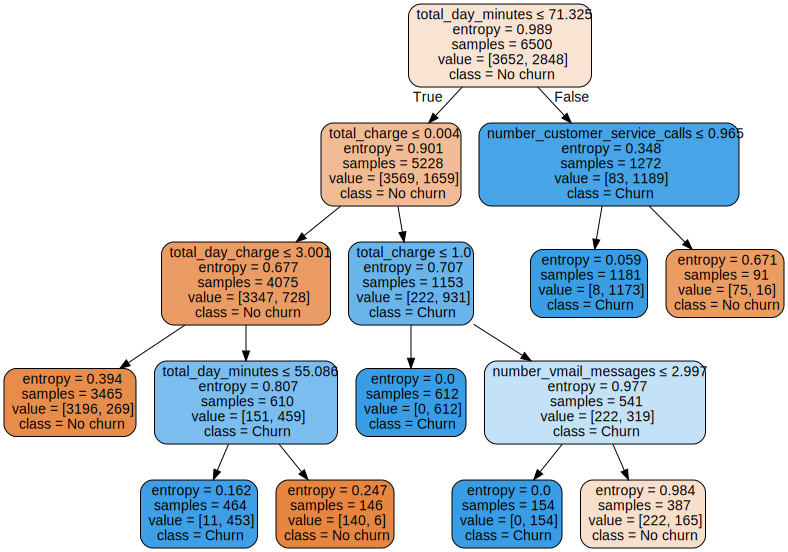

In [92]:
# get feature names
numeric_features = [
    'total_charge', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 
    'total_minutes', 'total_intl_calls', 'total_intl_minutes', 'number_vmail_messages', 'total_intl_charge'
]
binary_features = ['international_plan', 'voice_mail_plan']
feature_names = np.append(numeric_features, binary_features)

# plot tree from our model
import graphviz 
from sklearn import tree
tree_graph = tree.export_graphviz(clf, out_file=None, 
                              feature_names=feature_names,  
                              class_names=['No churn', 'Churn'],  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(tree_graph) 
graph 

<img src="data/blog_content/tree.png" align="center"/>

Each node in the tree will give a condition and the left node below is True and the right node is False.
The first split was performed with the total day minutes feature, which counts the total minutes of all calls made in the day. We can see for example that if the total minutes is less than 71 we follow the tree left and if the minutes is greater than 71 we go right. 

Each prediction from the tree is made by following the tree down until a root node is hit. For example, if a customer has less than 71 total day minutes and there total charge is between 0.04 and 1 then we would predict them to churn. 

We can see that the charge from the telecom provider seems to be a big distinguishing factor between customers and this is confirmed by the SHAP feature importance plot earlier. By following the tree left we can see that customers with a high day charge but low day minutes tend to churn more than stay. If the day charge is less than 3 however, the customers tend to stay no matter what the minutes are! One possible explanation to this could be that the customers churning are on mobile plans that don't correctly suit their needs, this would need to be investigated further though. 

Another interesting observation is that if a customer has a high total day minutes ($\geq 71$) and they do not speak to customer service ($\leq  0.965$ calls i.e. no calls) they are more likely to churn than customers that do speak to customer service. Again, this would need further investigation to draw conclusions as to why this is true. 

As with most data problems, it quite often leads to more questions to be answered!

### Conclusion 
We have built an interpretable machine learning model that can identify customers that are likely to churn with our desired recall of 80% (we actually achieved 85% on the test set) and a precision of 75%. That is we identify 85% of the churned customers correctly and 75% of our churn predictions are accurate. Using this model we can then understand the key factors driving customers to leave and hopefully we can use this to try and keep more customers in the long run.  